### Drive Mount

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Initial Setting

In [2]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=aa05b94ac8cb737f8d6a1cfc0028efad4e2f1e480d346c8a7bc2580e154f78b3
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [3]:
from efficientnet_pytorch import EfficientNet
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import f1_score
import os
import glob
import logging
import torch
from torch import nn
import pickle
from tqdm import tqdm # progress bar
from torchvision import transforms
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.offline import plot

In [4]:
data_path = "/content/drive/MyDrive/Colab/Sketch_RNN/Sketch_RNN_Together/Dataset/Filtered_img/"
cluster_list_path = "/content/drive/MyDrive/Colab/Sketch_RNN/Sketch_RNN_lee/cluster_list/cluster_list_test_10.txt"
feat_path = "/content/drive/MyDrive/Colab/Sketch_RNN/Sketch_RNN_lee/features/features_lee_test_10.npy"
filename_path = "/content/drive/MyDrive/Colab/Sketch_RNN/Sketch_RNN_lee/filenames/filenames_lee_test_10.npy"
textfile_path = "/content/drive/MyDrive/Colab/Sketch_RNN/Sketch_RNN_lee/result.txt"
test_data_path = "/content/drive/MyDrive/Colab/Sketch_RNN/Sketch_RNN_Together/Dataset/input/eye/"

In [5]:
# make cluster_list : cluster label name files
cluster_list = open(cluster_list_path, 'r').read().split('\n')
# make option_list
option_list = {}

### Save Images

In [ ]:
# save images
images = np.load("/content/drive/MyDrive/Colab/Sketch_RNN/Sketch_RNN_lee/data/test/full_numpy_bitmap_mouth.npy")
os.chdir("/content/drive/MyDrive/Colab/Sketch_RNN/Sketch_RNN_lee/data/test")
for i in range(10000):
  image = Image.fromarray(images[i].reshape(28, 28))
  image.save(str(i) + '.jpg')

### Rename Files

In [ ]:
# rename files
def ChangeName(path, name):
    i = 0
    for filename in os.listdir(path):
        os.rename(path+filename, path+str(name)+'_'+str(i)+'.jpg')
        i += 1
ChangeName(data_path + "mouth/","mouth")

### Feature Extraction

In [6]:
# transform
tfms = transforms.Compose([transforms.Resize(224), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),]) # compose image (resize, totensor, normalize)
pooling = nn.AdaptiveAvgPool2d(1)

def ExtractFeature(image, model):
    img = tfms(Image.open(image).convert("RGB")).unsqueeze(0) # unsqueeze: vector to tensor
    features = model.extract_features(img)
    features = pooling(features)
    return features

In [ ]:
# efficientNet
# train data feature extraction
# data_list = [files for files in glob.glob(data_path + '*/*.jpg')]

# model = EfficientNet.from_pretrained('efficientnet-b0')
# data = {}
# for i, image in enumerate(tqdm(data_list)): # i for tuple data type
#   feat = ExtractFeature(image, model)
#   feat = feat.detach().numpy().reshape(-1) # detach: copy tensor without gradient
#   data[image] = (feat)

# np.save(feat_path, np.array(list(data.values()))) # get a list of the features
#np.save(filename_path, np.array(list(data.keys()))) # get a list of the filenames

In [7]:
# efficientNet
# test data feature extraction
test_data_list = [files for files in glob.glob(test_data_path + '*.jpg')]

model = EfficientNet.from_pretrained('efficientnet-b0')
test_data = {}
for i, image in enumerate(tqdm(test_data_list)):
  test_feat = ExtractFeature(image, model)
  test_feat = test_feat.detach().numpy().reshape(-1)
  test_data[image] = (test_feat)
test_filenames = np.array(list(test_data.keys()))
test_feat = np.array(list(test_data.values()))

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0/2 [00:00<?, ?it/s]


Loaded pretrained weights for efficientnet-b0


100%|██████████| 2/2 [00:00<00:00,  2.16it/s]


### Dimension Reduction

In [13]:
# load and combine train data feature and test data feature
feat = np.load(feat_path)
feat_n = feat.shape[0]
feat = np.insert(feat,feat_n,test_feat,axis=0)
filenames = np.load(filename_path)
filenames_n = filenames.shape[0]
filenames = np.insert(filenames,filenames_n,test_filenames,axis= 0)

In [ ]:
# PCA
# from sklearn.decomposition import PCA
# option_list['reduction'] = 'PCA'
# option_list['PCAComponents'] = 2
# pca = PCA(n_components=option_list['PCAComponents'], random_state=0)
# pca.fit(feat)
# x = pca.transform(feat)

In [9]:
# TSNE
from sklearn.manifold import TSNE
option_list['reduction'] = 'TSNE'
option_list['TSNEComponents'] = 2
tsne = TSNE(n_components=option_list['TSNEComponents'], init='pca', random_state=0)
x = tsne.fit_transform(feat)

### Clustering

In [17]:
def Cluster(cmd, cluster_num, input):
  if cmd == 'kmeans':
    from sklearn.cluster import KMeans
    option_list['clustering'] = 'KMeans'
    kmeans = KMeans(n_clusters = cluster_num, n_jobs = -1, random_state = 0)
    kmeans.fit(input)
    return kmeans.labels_
  elif cmd == 'dbscan':
    from sklearn.cluster import DBSCAN
    option_list['clustering'] = 'DBSCAN'
    option_list['DBEps'] = 1.3
    option_list['DBMinSamples'] = 2
    dbscan = DBSCAN(eps=option_list['DBEps'], min_samples=option_list['DBMinSamples'])
    dbscan.fit(input)
    return dbscan.labels_

In [18]:
labels = Cluster('kmeans', len(cluster_list), x)

In [19]:
os.chdir("/content/drive/MyDrive/Colab/Sketch_RNN/Sketch_RNN_lee")
fig = px.scatter(x, x=0, y=1, color = labels)
plot(fig)

'temp-plot.html'

### KNN

In [ ]:
knn = NearestNeighbors(n_neighbors=6, algorithm='auto').fit(x) # Unsupervised learner for implementing neighbor searches
distanceArray = []
indexArray = []
for i in range(len(test_data_list)):
  backIndex = -1 * (i + 1);
  distances, indices = knn.kneighbors([list(x[backIndex])])
  distanceArray.append(distances)
  indexArray.append(indices)

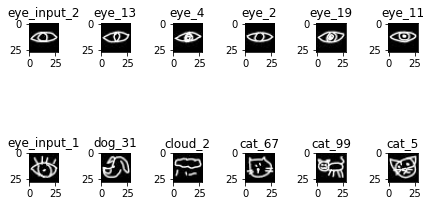

In [42]:
neighborImagesArray = []
neighborNamesArray = []

for indices in indexArray:
  neighborImages = []
  neighborNames = []
  for index in indices[0]:
    neighborImages.append(np.array(Image.open(filenames[index])))
    neighborNames.append(filenames[index].split('/')[-1].split('.')[0])
  neighborImagesArray.append(neighborImages)
  neighborNamesArray.append(neighborNames)

for i, img in enumerate(neighbor_images):
  plt.subplot(len(test_data_list), 6, i+1)
  plt.title(neighbor_names[i])
  plt.imshow(img, 'gray')

plt.tight_layout()
plt.show()

### Calculating Accuracy

In [16]:
# get key by value in nested dictionary
def GetKey(myValue, myDict):
  for key, values in myDict.items():
    for value in values:
         if myValue == value:
             return key
  return "none"

In [20]:
# holds the cluster id and the images { id: [images] }
groups = {}
for f, cluster in zip(filenames, labels):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(f)
    else:
        groups[cluster].append(f)

# make cluster_dict for calculate acc
cluster_dict = {}
for cluster in groups:
  image_count = []
  image_name = []
  for image in groups[cluster]:
    image_name.append(image.split('/')[-2])
  for name in cluster_list:
    image_count.append(image_name.count(name))
  cluster_dict[cluster] = cluster_list[image_count.index(max(image_count))] # Select the most frequently classified label as the correct label
option_list['clusterDictSize'] = len(cluster_dict)

# get accuracy
ans = []
result = []    
for cluster in groups:
    for category in groups[cluster]:
        ans.append(cluster_dict[cluster])
        result.append(category.split('/')[-2])
acc = str(round(f1_score(result, ans, average='micro') * 100, 2)) + '%'
option_list['accuracy'] = acc
print(acc)

# check answer
for filename in test_filenames:
  testKey = GetKey(filename, groups)
  testAns = filename.split('/')[-2]
  testResult = cluster_dict[testKey]
  if (testAns == testResult):
    print('correct!')
  else:
    print('wrong...')
  print('test: ' + testAns + ', result: ' + testResult)

70.61%
wrong...
test: eye, result: cat
correct!
test: eye, result: eye


In [21]:
# write the result on textfile
f = open(textfile_path, 'a', encoding='UTF-8')
for key, value in option_list.items():
  f.write(f'{value} ')
f.write(f'\n')
f.close()